In [108]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met, u_darrays as uda
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import matplotlib.patches as patches
import pickle

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [107]:
cd ..

/home/ck/pythonWorkspace


In [109]:
fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb"))

shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
tcwvfac_all =  np.array(ftcw['rel']) 

precip_all = ftcw['prcp_hist']

tcabsfac = np.array(ftcw['abs']) #1.21 # absolute change
tcabsfac[0] = tcabsfac[1]

tcabserr = np.std(ftcw['abs']) #0.06 #mm h
tcrelerr = np.std(ftcw['rel']) #0.18 #%

In [110]:
print('Shear scaling', shearfac)
print('TCW scaling', tcwvfac_all)

Shear scaling 0.7003135334190702
TCW scaling [1.16296269 1.14583054 1.16296269 1.19185658 1.10917452 1.16007311
 1.09546043 1.1853091  1.13894869 1.32547751 1.20666992 1.30495387
 1.22251442 1.3176084  1.23383721 1.26747419 1.46585397 1.32938129
 1.4510043  1.45911276]


In [111]:
obs_mcs = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "rb"))
cp4hist_mcs = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "rb"))
cp4fut_mcs = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "rb"))

In [112]:
ftcw.keys()

dict_keys(['rel', 'abs', 'futslope', 'histslope', 'futinter', 'histinter', 'tcw_hist', 'prcp_hist'])

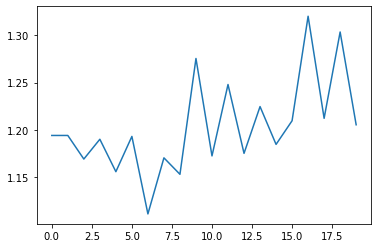

In [113]:
plt.plot(tcabsfac)

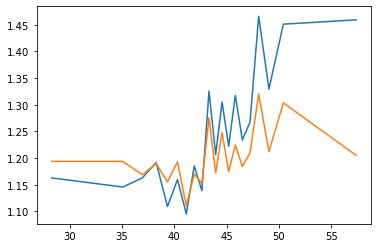

In [114]:
plt.plot(ftcw['tcw_hist'],tcwvfac_all)
plt.plot(ftcw['tcw_hist'], tcabsfac)

In [115]:
obs_mcs.keys()

Index(['prcp', 'q925', 'q650', 't925', 'pall', 'shear', 'month', 'area',
       'tmin', 'rh', 'theta_e', 'theta_es', 'tcwv', 'tgrad', 'tbox', 'lat',
       'lon'],
      dtype='object')

In [116]:
domain=[-2.52,0.52,11.38,13.38]
#    dicout = dic[(dic.lon>=domain[0])&(dic.lon<=domain[1])&(dic.lat>=domain[2])&(dic.lat<=domain[3])& (dic.month>=m1) & (dic.month<=m2) & (dic.q925>=8.) & (dic.shear>0) &  (dic.prcp>=8) & (dic.theta_e>=-40) & (dic.area>=5000) & (dic.tmin<=-55)]

test = cp4hist_mcs[(cp4hist_mcs.lon>=domain[0])&(cp4hist_mcs.lon<=domain[1])&(cp4hist_mcs.lat>=domain[2])&(cp4hist_mcs.lat<=domain[3])]
np.nanmean(test.tcwv)

45.386149540341364

In [117]:
cp4_tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc')
cp4_tcw_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_tcwv_daily.nc')
cp4_prcp_fut = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_p95Rain_gt5mm.nc')
cp4_prcp_hist = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_p95Rain_gt5mm.nc')

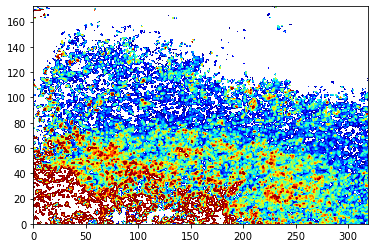

In [118]:
plt.contourf(cp4_prcp_fut-cp4_prcp_hist, cmap='jet', levels=np.arange(15,61,2))

In [119]:
cp4_u925_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u925_daily.nc')
cp4_u925_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u925_daily.nc')
cp4_u600_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u600_daily.nc')
cp4_u600_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u600_daily.nc')

In [120]:
cp4_shear_hist = cp4_u925_hist-cp4_u600_hist
cp4_shear_fut = cp4_u925_fut-cp4_u600_fut

In [121]:
cp4_prcp_fut.name = 'prcp'
cp4_prcp_hist.name = 'prcp'

In [122]:
cmip_tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc', concat_dim='model_name', combine='by_coords').load()

In [123]:
cmip_tcw_map.model_name

<xarray.DataArray 'model_name' (model_name: 38)>
array(['ACCESS1-0', 'ACCESS1-3', 'BNU-ESM', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5',
       'CMCC-CESM', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5', 'CSIRO-Mk3-6-0',
       'CanESM2', 'FGOALS-g2', 'FIO-ESM', 'GFDL-CM3', 'GFDL-ESM2G',
       'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC',
       'HadGEM2-CC', 'HadGEM2-ES', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR',
       'IPSL-CM5B-LR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'MPI-ESM-LR',
       'MPI-ESM-MR', 'MRI-CGCM3', 'MRI-ESM1', 'NorESM1-M', 'NorESM1-ME',
       'bcc-csm1-1', 'bcc-csm1-1-m', 'inmcm4'], dtype=object)
Coordinates:
  * model_name  (model_name) object 'ACCESS1-0' 'ACCESS1-3' ... 'inmcm4'

In [124]:
cmip_shear_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/u*.nc', concat_dim='model_name', combine='by_coords').load()

In [125]:
box = [-15,15,3.5,22]

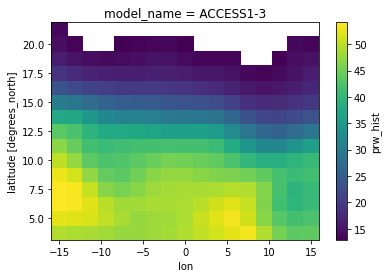

In [126]:
cmip_tcw_map['prw_hist'].sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]), model_name='ACCESS1-3').plot()

In [127]:
ds_merge = xr.merge([cmip_tcw_map, cmip_shear_map])

In [128]:
ds_merge

<xarray.Dataset>
Dimensions:       (lat: 25, lon: 27, model_name: 38)
Coordinates:
  * model_name    (model_name) object 'ACCESS1-0' 'ACCESS1-3' ... 'inmcm4'
  * lat           (lat) float64 0.0 1.25 2.5 3.75 5.0 ... 26.25 27.5 28.75 30.0
  * lon           (lon) float64 -24.38 -22.5 -20.62 -18.75 ... 20.62 22.5 24.38
Data variables:
    prw           (model_name, lat, lon) float64 13.08 13.08 13.04 ... nan nan
    prw_hist      (model_name, lat, lon) float64 39.04 38.67 38.36 ... nan nan
    unknown       (model_name, lat, lon) float64 3.048 3.147 3.187 ... nan nan
    unknown_hist  (model_name, lat, lon) float64 1.485 1.618 1.808 ... nan nan

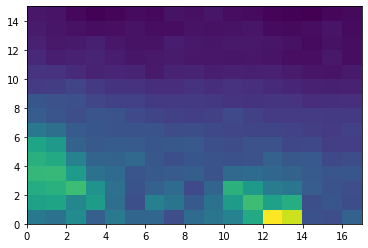

In [129]:
ds_merge = ds_merge.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))
cp4_tcw_onCmip = ds_merge.salem.lookup_transform(cp4_tcw_hist)
cp4f_tcw_onCmip = ds_merge.salem.lookup_transform(cp4_tcw_fut)
cp4f_prcp_onCmip = ds_merge.salem.lookup_transform(cp4_prcp_fut)
cp4_prcp_onCmip = ds_merge.salem.lookup_transform(cp4_prcp_hist)

plt.pcolormesh(cp4f_prcp_onCmip)

In [130]:
cp4f_shear_onCmip = ds_merge.salem.lookup_transform(cp4_shear_fut)
cp4_shear_onCmip = ds_merge.salem.lookup_transform(cp4_shear_hist)

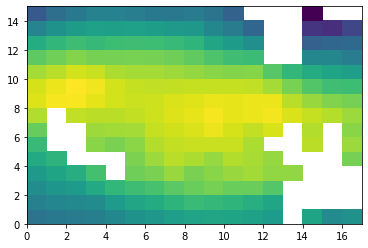

In [131]:
plt.pcolormesh(cp4_shear_onCmip['u_pl'])

In [132]:
cp4_tcw_onCmip.lon.values[1::]-cp4_tcw_onCmip.lon.values[0:-1]

array([1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875])

In [136]:
mcs_gridded = cp4_tcw_onCmip['tcwv']
def add_lonlat_todic(dic,grid):
    try:
        del dic['grid_lon']
        del dic['grid_lat']
    except:
        pass
    grid_lon = []
    grid_lat = []
    for lonx, laty in zip(dic.lon, dic.lat):
        point = grid.sel(lat=laty, lon=lonx, method='nearest') #, tolerance=0.9

        grid_lat.append(float(point.lat.values))
        grid_lon.append(float(point.lon.values))
    dic['grid_lon'] = grid_lon
    dic['grid_lat'] = grid_lat

In [137]:
add_lonlat_todic(obs_mcs, mcs_gridded)

In [138]:
add_lonlat_todic(cp4hist_mcs, mcs_gridded)

In [139]:
add_lonlat_todic(cp4fut_mcs, mcs_gridded)

In [140]:
def assign_to_grid(dic, grid, var):
    mcs_array = np.zeros_like(grid.values)*np.nan
    for yy, lat in enumerate(grid.lat):
        for xx, lon in enumerate(grid.lon):
            
            posi = np.where((dic['grid_lon']==lon) & (dic['grid_lat']==lat))
            precip = np.array(dic[var])[posi]
            valid = np.sum(precip>1)

            try:
                perc = np.percentile(precip[precip>8], 95)
            except:
                perc = np.nan
            if valid < 25:
                perc=np.nan
            mcs_array[yy,xx] = perc
    outarr = grid.copy(deep=True)
    outarr.values = mcs_array
    return outarr         

In [141]:
def assign_to_grid_mean(dic, grid, var):
    mcs_array = np.zeros_like(grid.values)*np.nan
    for yy, lat in enumerate(grid.lat):
        for xx, lon in enumerate(grid.lon):
            
            posi = np.where((dic['grid_lon']==lon) & (dic['grid_lat']==lat))
            precip = np.array(dic[var])[posi]
            #valid = np.sum(precip>1)

            try:
                perc = np.nanmean(precip)
            except:
                perc = np.nan
#             if valid < 25:
#                 perc=np.nan
            mcs_array[yy,xx] = perc
    outarr = grid.copy(deep=True)
    outarr.values = mcs_array
    return outarr

In [142]:
obs_mcs_grid = assign_to_grid(obs_mcs,mcs_gridded, 'prcp')

In [143]:
obs_tcw_grid = assign_to_grid_mean(obs_mcs,mcs_gridded, 'tcwv')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init

In [144]:
obs_shear_grid = assign_to_grid_mean(obs_mcs,mcs_gridded, 'shear')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init

In [145]:
cp4f_mcs_grid = assign_to_grid(cp4fut_mcs,mcs_gridded, 'prcp')

In [146]:
cp4_mcs_grid = assign_to_grid(cp4hist_mcs,mcs_gridded, 'prcp')

In [147]:
mcs_cp4_diff = cp4f_mcs_grid-cp4_mcs_grid

In [160]:
cp4_mcs_grid

<xarray.DataArray 'tcwv' (lat: 15, lon: 17)>
array([[      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan],
       [      nan,       nan,       nan,       nan, 42.38255 ,       nan,
              nan,       nan,       nan,       nan,       nan, 55.27043 ,
        51.169937, 43.2449  , 39.12983 ,       nan,       nan],
       [      nan,       nan, 52.709805, 53.29016 , 40.55305 , 44.272816,
        50.72667 , 46.797207, 46.823753,       nan, 49.48803 , 49.497684,
        51.113155, 49.19507 , 47.699516, 41.600494,       nan],
       [      nan,       nan, 54.981632, 47.33741 , 47.496807, 48.2307  ,
        47.750004, 45.645485, 50.62309 , 52.056877, 55.244133, 55.054325,
        53.979195, 46.256744, 48.004803, 42.482048,       nan],
       [      nan,       nan, 53.66643 , 47.493633, 49.536396, 50.160084,
        53.532066, 53.90588 , 46.47675 , 52.398838, 51.62746 , 50.53852 ,
        48.263046, 47.826607, 45.12971 , 47.441074,       nan],
       [      nan,       nan, 52.638515, 46.943096, 46.457527, 47.90768 ,
        45.05006 , 47.05275 , 48.98535 , 49.438774, 47.283802, 46.750282,
        47.140877, 47.841064, 45.83451 , 48.236908,       nan],
       [      nan,       nan, 45.89644 , 46.041668, 47.41424 , 45.342087,
        43.612003, 45.881832, 46.55375 , 46.31469 , 43.383476, 47.43259 ,
...
        38.54498 , 37.089714, 40.251358, 38.53859 ,       nan],
       [      nan,       nan, 37.837982, 39.81349 , 38.073414, 37.017567,
        34.67272 , 35.433266, 36.98612 , 32.487244, 31.634445, 35.008675,
        35.82111 , 35.73371 , 31.820335, 31.92886 ,       nan],
       [      nan,       nan, 37.191814, 36.343   , 34.830914, 33.76251 ,
        33.681004, 33.335655, 31.176344, 33.636158, 32.2578  , 32.84274 ,
        31.457212, 28.769268, 28.64938 ,       nan,       nan],
       [      nan,       nan, 31.4417  , 36.557766, 29.498758, 33.355217,
        32.51536 , 34.096893, 30.224066, 29.525917, 35.006733, 26.484648,
        30.469734,       nan,       nan,       nan,       nan],
       [      nan,       nan, 32.326786, 30.491566, 26.939056, 28.868258,
        24.548187, 27.184664, 24.232622, 24.49198 ,       nan, 30.582552,
        25.90287 ,       nan,       nan,       nan,       nan],
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan],
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan]],
      dtype=float32)
Coordinates:
  * lon      (lon) float64 -15.0 -13.12 -11.25 -9.375 ... 9.375 11.25 13.12 15.0
  * lat      (lat) float64 3.75 5.0 6.25 7.5 8.75 ... 17.5 18.75 20.0 21.25
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

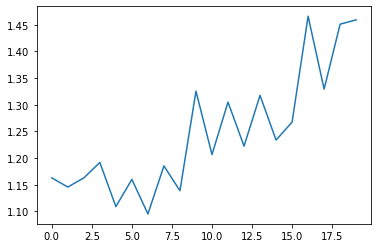

In [150]:
plt.plot(tcwvfac_all)

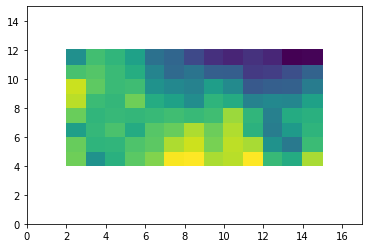

In [151]:
plt.pcolormesh(obs_tcw_grid)

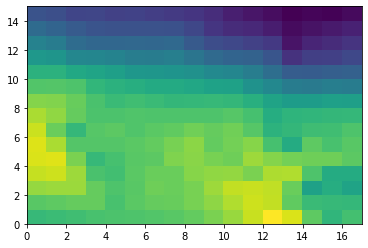

In [152]:
plt.pcolormesh(cp4_tcw_onCmip['tcwv'].values)

In [153]:
cp4_pos_array = np.zeros_like(cp4_tcw_onCmip['tcwv'].values)*np.nan
for x in range((cp4_tcw_onCmip['tcwv'].values).shape[1]):
    for y in range((cp4_tcw_onCmip['tcwv'].values).shape[0]):
        pix = cp4_tcw_onCmip['tcwv'].values[y,x]
        try:
            isclose = np.nanargmin(np.abs(pix-ftcw['tcw_hist']))
        except ValueError:
            cp4_pos_array[y,x] = np.nan
            continue
       # ipdb.set_trace()
        cp4_pos_array[y,x] = tcwvfac_all[isclose]

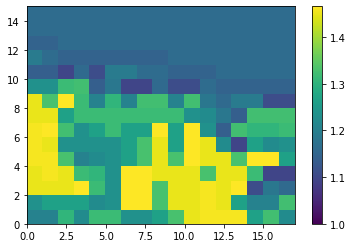

In [154]:
plt.pcolormesh(cp4_pos_array, vmin=1)
plt.colorbar()

In [155]:
def percentile_contribution(p90, ds_merge):
    contr = p90.copy(deep=True)
    fillarr = np.zeros_like(p90.values)*np.nan

    for latid, lats in enumerate(p90.lat):
        for lonid, lons in enumerate(p90.lon):

            ds = ds_merge.sel(lat=lats, lon=lons)

            if np.isnan(p90.sel(lat=lats, lon=lons).values):
                continue
            
            pos = np.where(p90.sel(lat=lats, lon=lons).values == ds['sum'].values)
           # ipdb.set_trace()
            try:
                #ipdb.set_trace()
                ctr = ds['contribution'].isel(model_name=pos[0]).values
                fillarr[latid, lonid] = ctr
            except:
                print('Error')
                continue
    contr.values = fillarr
    return contr

In [156]:
def draw_map(ax, dat, lat, lon, title='', levels=None, cbarlabel='', cmap='', bl=False, ll=True):
    import matplotlib.ticker as mticker
    
    ax.set_facecolor('lightgrey')
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels, alpha=0.7, extend='both')
    cbar = plt.colorbar()
    cbar.set_label(cbarlabel)
    plt.contour(lon, lat, dat, transform=ccrs.PlateCarree(), colors='white', levels=levels, linewidths=0.1)
    ax.coastlines()
    #Gridlines
    xl = ax.gridlines(draw_labels=True, linestyle='dotted', linewidths=0.001);
    xl.top_labels = False
    xl.right_labels = False
    xl.bottom_labels = bl
    xl.left_labels = ll
    xl.ylocator = mticker.FixedLocator([5,10,15,20])
    #xl.grid(False)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', linewidth=0.5);
    plt.title(title, fontsize=10)
    ax.set_ylim(3.7,21)
    ax.set_xlim(-14,14)
    
    ax.plot(-1.52, 12.38, marker='o',  color='k', linestyle='', markersize=2)  #transform=ax.transAxes,
    rect2 = patches.Rectangle((-1.52-1,12.38-1),2,2,linewidth=1,edgecolor='k',facecolor='none', zorder=99)
    
    rect1 = patches.Rectangle((-12,9),24,10,linewidth=1.5,edgecolor='k',facecolor='none', zorder=98)
    ax.add_patch(rect1)
    ax.add_patch(rect2)


In [157]:
def gauss(data, sigma):
    sigma=sigma                  # standard deviation for Gaussian kernel
    truncate=4.0               # truncate filter at this many sigmas

    U=data       # random array...

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

In [167]:
cp4_pos_array = np.zeros_like(cp4_tcw_onCmip['tcwv'].values)*np.nan
cp4_pcp_array = np.zeros_like(cp4_tcw_onCmip['tcwv'].values)*np.nan
for x in range((cp4_tcw_onCmip['tcwv'].values).shape[1]):
    for y in range((cp4_tcw_onCmip['tcwv'].values).shape[0]):
        pix = cp4_mcs_grid.values[y,x]#cp4_tcw_onCmip['tcwv'].values[y,x]
        if pix < np.min(ftcw['tcw_hist'])-1:
            continue
        if pix > np.max(ftcw['tcw_hist'])+1:
            continue
            
        try:
            isclose = np.nanargmin(np.abs(pix-ftcw['tcw_hist']))
        except ValueError:
            #cp4_pos_array[y,x] = np.nan
            continue
        cp4_pos_array[y,x] = tcwvfac_all[isclose]
        cp4_pcp_array[y,x] = ftcw['prcp_hist'][isclose]

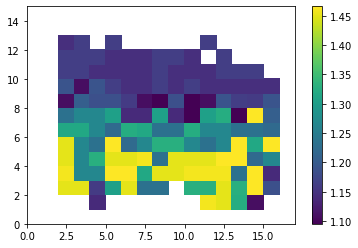

In [168]:
plt.pcolormesh(cp4_pos_array)
plt.colorbar()

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Text(0, 4, 'f')

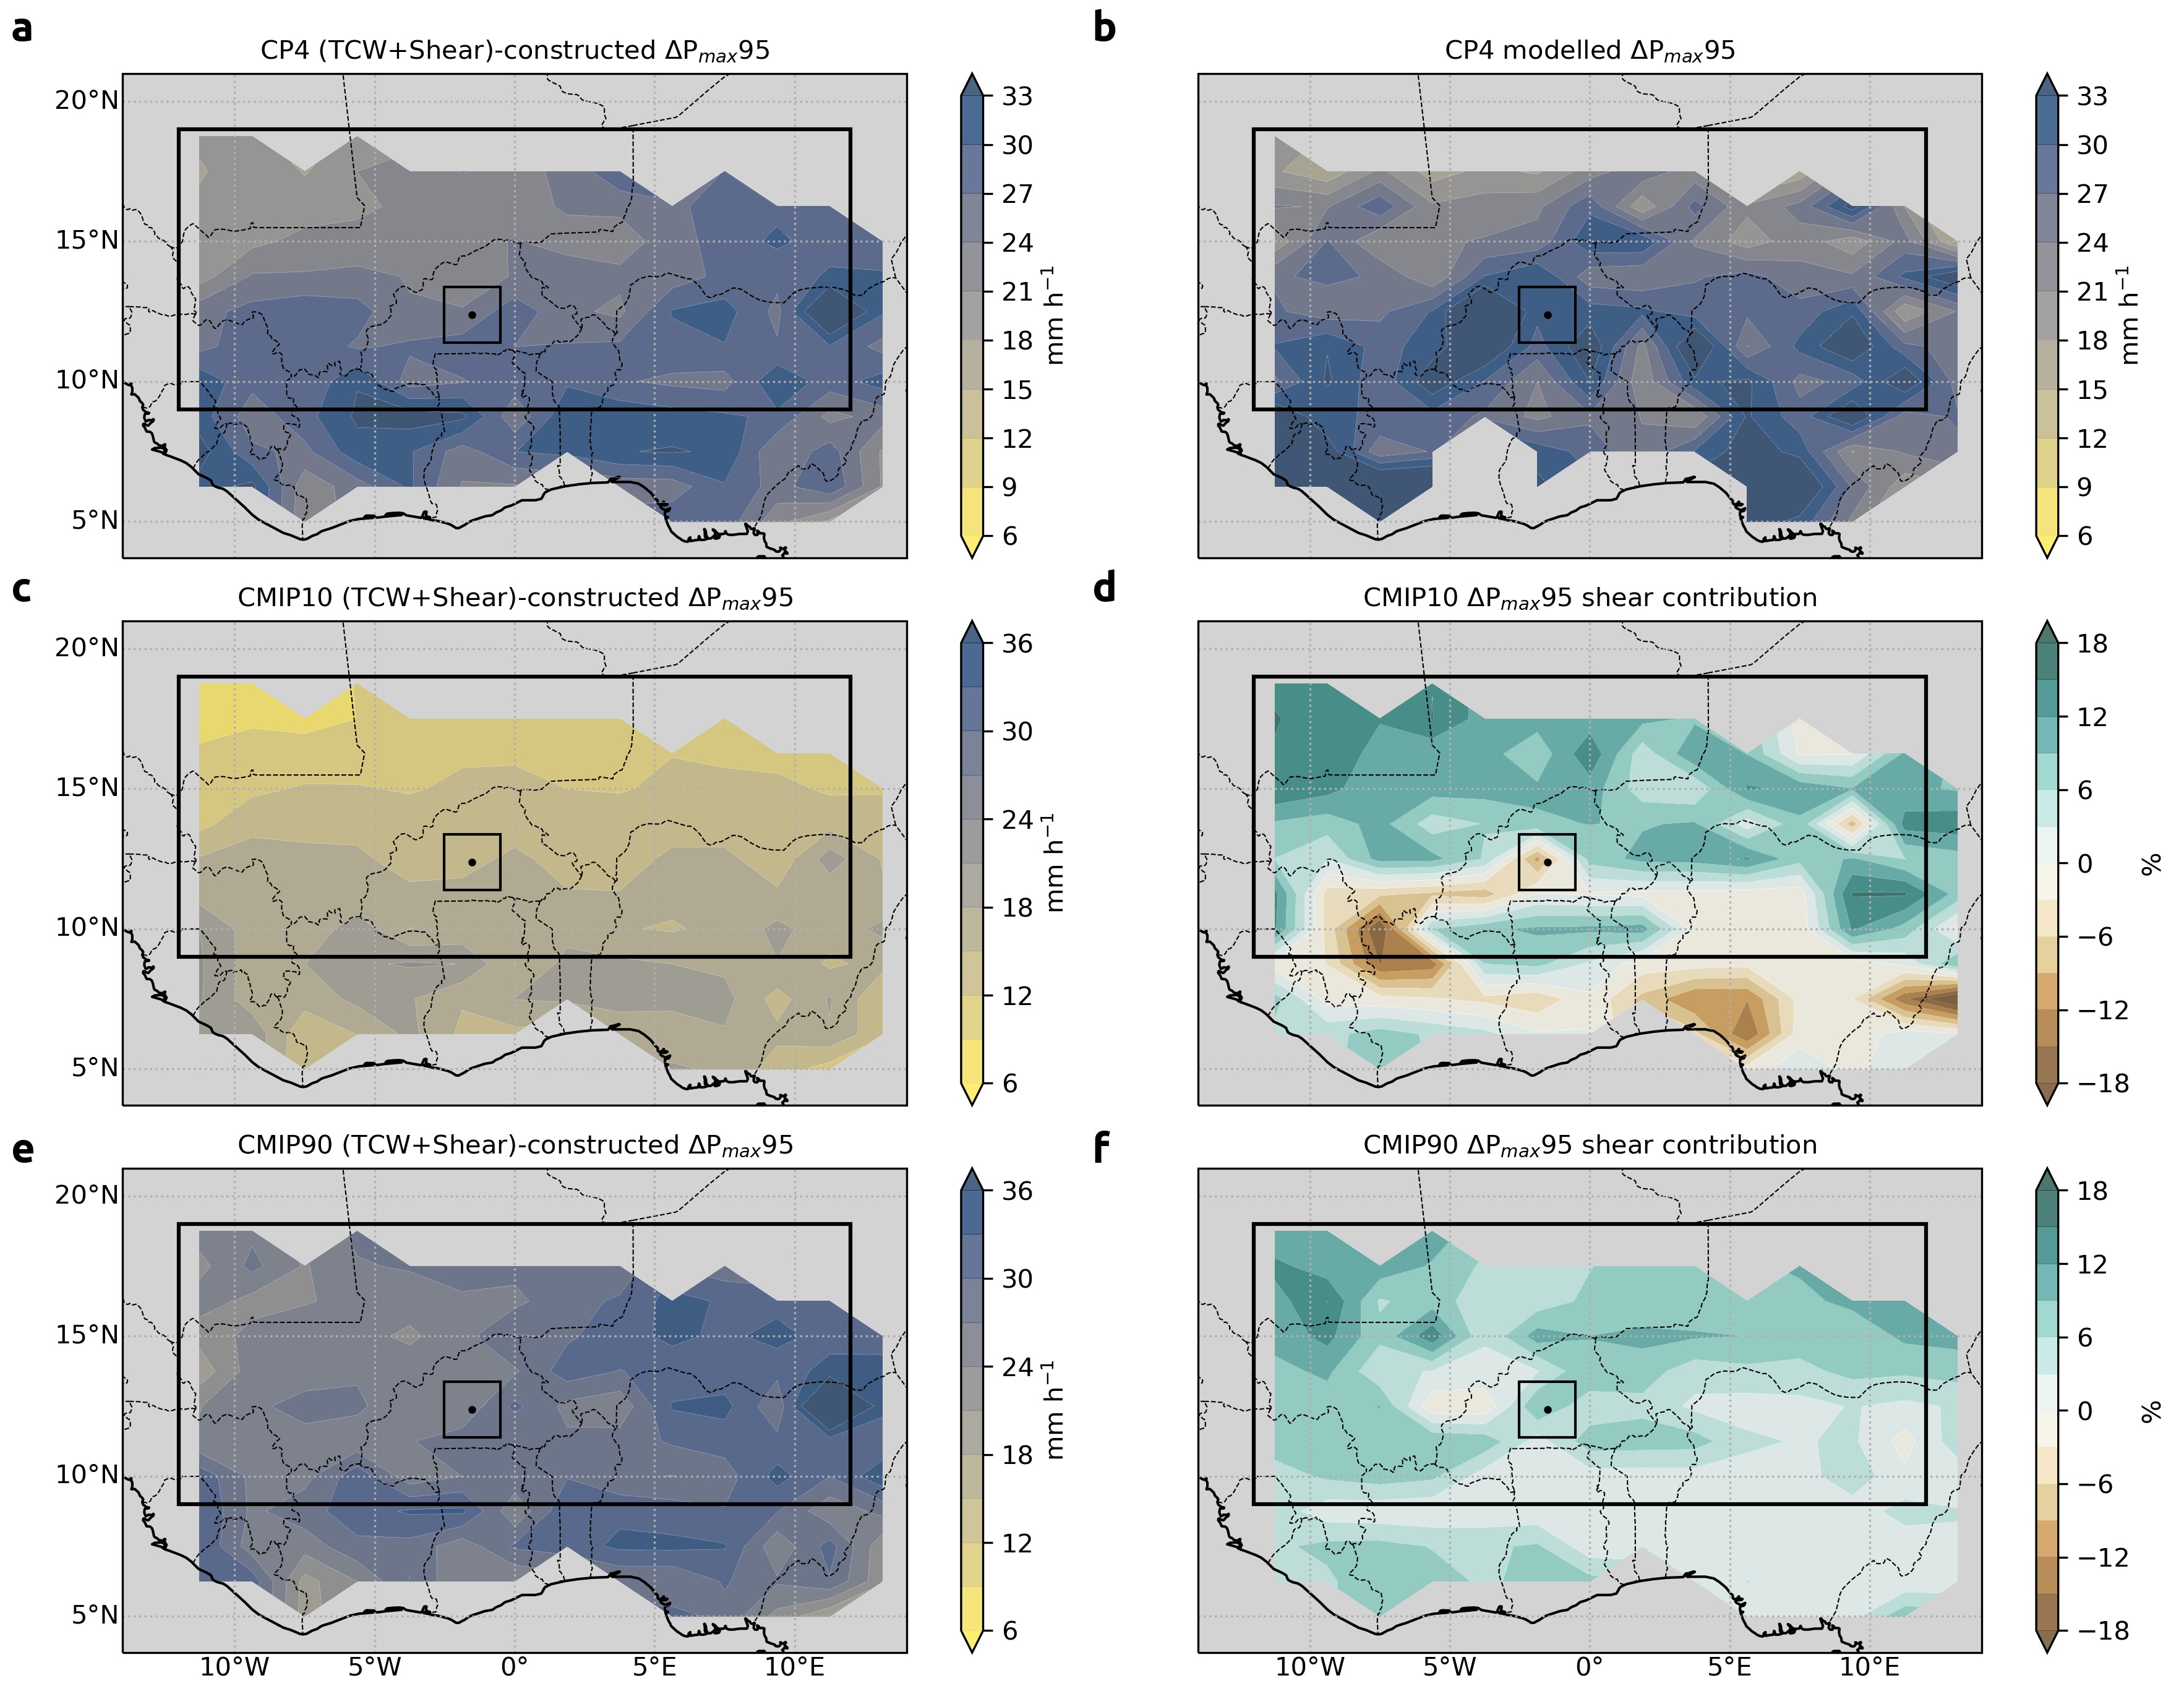

In [166]:
cp4_pos_array = np.zeros_like(cp4_tcw_onCmip['tcwv'].values)*np.nan
cp4_pcp_array = np.zeros_like(cp4_tcw_onCmip['tcwv'].values)*np.nan
for x in range((cp4_tcw_onCmip['tcwv'].values).shape[1]):
    for y in range((cp4_tcw_onCmip['tcwv'].values).shape[0]):
        pix = cp4_mcs_grid.values[y,x]#cp4_tcw_onCmip['tcwv'].values[y,x]
        if pix < np.min(ftcw['tcw_hist'])-1:
            continue
        if pix > np.max(ftcw['tcw_hist'])+1:
            continue
            
        try:
            isclose = np.nanargmin(np.abs(pix-ftcw['tcw_hist']))
        except ValueError:
            #cp4_pos_array[y,x] = np.nan
            continue
        cp4_pos_array[y,x] = tcwvfac_all[isclose]
        cp4_pcp_array[y,x] = ftcw['prcp_hist'][isclose]

notfinite = np.isnan(cp4_pos_array)
f = plt.figure(figsize=(12,9), dpi=300)

ax = f.add_subplot(3,2,1, projection=ccrs.PlateCarree())
# pcp associated via tcw associated via climate vectors
p_tcw_change = ((cp4f_tcw_onCmip['tcwv']-cp4_tcw_onCmip['tcwv'])/cp4_tcw_onCmip['tcwv']) * gauss((cp4_mcs_grid.values),0.25) * cp4_pos_array #* cp4_pcp_array # 0.55

#p_tcw_change = ((cp4f_tcw_onCmip['tcwv']-cp4_tcw_onCmip['tcwv'])/cp4_tcw_onCmip['tcwv']) * gauss((obs_mcs_grid),0.35) * obs_pos_array
#p_tcw_change = ((cp4f_tcw_onCmip['tcwv']-cp4_tcw_onCmip['tcwv'])/cp4_tcw_onCmip['tcwv']) * cp4_pos_array *100  #cp4_pcp_array

p_shear_change = (cp4f_shear_onCmip['u_pl']-cp4_shear_onCmip['u_pl'])*shearfac

p_shear_change.values[np.isnan(p_shear_change.values)] = 0
#shear_perc_contrib = p_shear_change/(p_shear_change+p_tcw_change_abs)*100
#ipdb.set_trace()
draw_map(ax, p_tcw_change+p_shear_change, cp4f_tcw_onCmip.lat, cp4f_tcw_onCmip.lon, title='CP4 (TCW+Shear)-constructed $\Delta$P$_{max}95$', levels=np.arange(6,36,3), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r', bl=False) 


ax1 = f.add_subplot(3,2,2, projection=ccrs.PlateCarree())  #cp4f_mcs_grid-gauss(cp4_mcs_grid,0.25) 
p_prcp_change = cp4f_mcs_grid.values-cp4_mcs_grid.values #(cp4f_mcs_grid- #gauss(((cp4f_prcp_onCmip-cp4_prcp_onCmip)/cp4_prcp_onCmip*100).values, 0.65)#gauss((cp4f_mcs_grid-cp4_mcs_grid)/cp4_mcs_grid*100,0.65) #gauss(cp4f_mcs_grid-cp4_mcs_grid,0.55)  #(cp4f_prcp_onCmip-cp4_prcp_onCmip) #(cp4f_mcs_grid-


#ipdb.set_trace()
p_prcp_change[notfinite] = np.nan 
#gauss(p_prcp_change,0.85)
draw_map(ax1, p_prcp_change, cp4f_tcw_onCmip.lat, cp4f_tcw_onCmip.lon, title='CP4 modelled $\Delta$P$_{max}95$', levels=np.arange(6,36,3), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r', bl=False, ll=False)
#draw_map(ax1, p_prcp_change, ds_merge.lat, ds_merge.lon, title='CP4 modelled P$_{max}95$ change ', levels=np.arange(6,37,2), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r', bl=True)
#gauss(cp4f_prcp_array-cp4_pcp_array,0.85)

slevels=np.arange(-18,19,3)
tag='10'
yy ='2080'
tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'/prw_*.nc', concat_dim='model_name', combine='by_coords').load()
sh_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'/u*.nc', concat_dim='model_name', combine='by_coords').load()
cp4_tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc')

ds_merge = xr.merge([tcw_map, sh_map])
ds_merge = ds_merge.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))
##relative CMIP change
ds_shear = ds_merge['unknown']*shearfac
cmip_rel = (ds_merge['prw']/ds_merge['prw_hist']).where(ds_merge['prw_hist']>21.5)

ar_list = []
for mids in ds_merge['prw'].model_name:
   
    new_ar_list =   cmip_rel.sel(model_name=mids) *cp4_pos_array * gauss((cp4_mcs_grid.values),0.25) #
    new_ar_list.name = 'prw'
    ar_list.append(new_ar_list)

ds_scaled = xr.concat(ar_list, dim='model_name')
ds_merge['sum'] =  ds_shear +ds_scaled  #
ds_merge['contribution'] = ds_shear/ ds_merge['sum']*100

p90 = ds_merge['sum'].quantile(0.90, dim='model_name', skipna=True, interpolation='nearest')
p10 = ds_merge['sum'].quantile(0.10, dim='model_name', skipna=True, interpolation='nearest')

contr90 = percentile_contribution(p90, ds_merge)
contr10 = percentile_contribution(p10, ds_merge)

ax = f.add_subplot(3,2,3, projection=ccrs.PlateCarree())
draw_map(ax, p10, ds_merge.lat, ds_merge.lon, title='CMIP'+tag+' (TCW+Shear)-constructed $\Delta$P$_{max}95$', levels=np.arange(6,39,3), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r') 

ax1 = f.add_subplot(3,2,4, projection=ccrs.PlateCarree())
draw_map(ax1, contr10, ds_merge.lat, ds_merge.lon,  title='CMIP'+tag+' $\Delta$P$_{max}95$ shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', ll=False)

tag='90'
ax = f.add_subplot(3,2,5, projection=ccrs.PlateCarree())
draw_map(ax, p90, ds_merge.lat, ds_merge.lon, title='CMIP'+tag+' (TCW+Shear)-constructed $\Delta$P$_{max}95$', levels=np.arange(6,39,3), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r', bl=True) 

ax1 = f.add_subplot(3,2,6, projection=ccrs.PlateCarree())
draw_map(ax1, contr90, ds_merge.lat, ds_merge.lon,  title='CMIP'+tag+' $\Delta$P$_{max}95$ shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', bl=True, ll=False)

plt.tight_layout()

text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

x1 = 0.005
x2 = 0.5

plt.annotate(text[0], xy=(x1, 0.97), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(x2, 0.97), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(x1, 0.64), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(x2, 0.64), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(x1, 0.31), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[5], xy=(x2, 0.31), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_scaled_map_rainfall_PercentileperPixel2080_absolute_CP4_8mm.jpg')

In [48]:
isclose = np.nanargmin(np.abs(pix-ftcw['tcw_hist']))

In [49]:
cp4_tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc')
cmip_dummy = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc')[0]).sel(lon=slice(-20,20), lat=slice(3.5,25))
cp4_tcw_onCmip = cmip_dummy.salem.lookup_transform(cp4_tcw_hist)
cp4_tcw_onCmip = cp4_tcw_onCmip.where(cp4f_tcw_onCmip>30)

cp4_pos_array = np.zeros_like(cp4_tcw_onCmip['tcwv'].values)*np.nan
cp4_pcp_array = np.zeros_like(cp4_tcw_onCmip['tcwv'].values)*np.nan
for x in range((cp4_tcw_onCmip['tcwv'].values).shape[1]):
    for y in range((cp4_tcw_onCmip['tcwv'].values).shape[0]):
        pix = cp4_tcw_onCmip['tcwv'].values[y,x]
        try:
            isclose = np.nanargmin(np.abs(pix-ftcw['tcw_hist']))
        except ValueError:
            #cp4_pos_array[y,x] = np.nan
            continue
        cp4_pos_array[y,x] = tcwvfac_all[isclose]
        cp4_pcp_array[y,x] = ftcw['prcp_hist'][isclose]


f = plt.figure(figsize=(11,10), dpi=200)

tag='10'
yy ='2040'
slevels=np.arange(-18,19,2)
tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'/prw_*.nc', concat_dim='model_name', combine='by_coords').load()
sh_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'/u*.nc', concat_dim='model_name', combine='by_coords').load()

ds_merge = xr.merge([tcw_map, sh_map])
ds_merge = ds_merge.sel(lon=slice(-20,20), lat=slice(3.5,25))

##relative CMIP change
ds_merge['unknown'] = ds_merge['unknown']*shearfac
cmip_rel = ds_merge['prw']/ds_merge['prw_hist']
ar_list = []
for mids in ds_merge['prw'].model_name:
    new_ar_list =  cmip_rel.sel(model_name=mids) * cp4_pos_array * cp4_pcp_array 
    new_ar_list.name = 'prw'
    ar_list.append(new_ar_list)

ds_scaled = xr.concat(ar_list, dim='model_name')

ds_merge['sum'] = ds_merge['unknown'] + ds_scaled
ds_merge['contribution'] = ds_merge['unknown']/ ds_merge['sum']*100

p90 = ds_merge['sum'].quantile(0.90, dim='model_name', skipna=True, interpolation='nearest')
p10 = ds_merge['sum'].quantile(0.10, dim='model_name', skipna=True, interpolation='nearest')

contr90 = percentile_contribution(p90, ds_merge)
contr10 = percentile_contribution(p10, ds_merge)

ax = f.add_subplot(4,2,1, projection=ccrs.PlateCarree())

#draw_map(ax, p10/mmPerPercent, ds_merge.lat, ds_merge.lon, title=tag+'th %tile constructed P$_{max}95$ change ', levels=np.arange(5,81,5), cbarlabel=r'%', cmap='cividis_r') 
draw_map(ax, p10, ds_merge.lat, ds_merge.lon, title=tag+'th %tile constructed P$_{max}95$ change ', levels=np.arange(6,34,2), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r') 
#plt.contour(ds_merge.lon, ds_merge.lat, contr10,  colors='k', linestyle='solid', linewidths=0.7, levels=[5,10,15,18,20])

ax1 = f.add_subplot(4,2,2, projection=ccrs.PlateCarree())
draw_map(ax1, contr10, ds_merge.lat, ds_merge.lon,  title=tag+'th %tile shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', ll=False) # YlOrBr

tag='90'
ax = f.add_subplot(4,2,3, projection=ccrs.PlateCarree())
#draw_map(ax, p90/ mmPerPercent, ds_merge.lat, ds_merge.lon, title=tag+'th %tile constructed P$_{max}95$ change ', levels=np.arange(5,81,5), cbarlabel=r'%', cmap='cividis_r') 
draw_map(ax, p90, ds_merge.lat, ds_merge.lon, title=tag+'th %tile constructed P$_{max}95$ change ', levels=np.arange(6,34,2), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r') 

ax1 = f.add_subplot(4,2,4, projection=ccrs.PlateCarree())
draw_map(ax1, contr90, ds_merge.lat, ds_merge.lon,  title=tag+'th %tile shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', ll=False)

del ds_merge
del tcw_map
del sh_map

tag='10'
yy ='2080'
tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'/prw_*.nc', concat_dim='model_name', combine='by_coords').load()
sh_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'/u*.nc', concat_dim='model_name', combine='by_coords').load()
cp4_tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc')

ds_merge = xr.merge([tcw_map, sh_map])
ds_merge = ds_merge.sel(lon=slice(-20,20), lat=slice(3.5,25))
##relative CMIP change
ds_merge['unknown'] = ds_merge['unknown']*shearfac
cmip_rel = (ds_merge['prw']/ds_merge['prw_hist']).where(ds_merge['prw_hist']>20)

ar_list = []
hist_masks = []
for mids in ds_merge['prw'].model_name:
    new_ar_list =  cmip_rel.sel(model_name=mids) * cp4_pos_array * cp4_pcp_array 
    new_ar_list.name = 'prw'
    ar_list.append(new_ar_list)
    #hist_masks.append(ds_merge['prw_hist']<20)

ds_scaled = xr.concat(ar_list, dim='model_name')
#ds_masks = xr.concat(hist_masks, dim='model_name')
    
ds_merge['sum'] = ds_merge['unknown'] + ds_scaled
ds_merge['contribution'] = ds_merge['unknown']/ ds_merge['sum']*100

p90 = ds_merge['sum'].quantile(0.90, dim='model_name', skipna=True, interpolation='nearest')
p10 = ds_merge['sum'].quantile(0.10, dim='model_name', skipna=True, interpolation='nearest')

contr90 = percentile_contribution(p90, ds_merge)
contr10 = percentile_contribution(p10, ds_merge)

ax = f.add_subplot(4,2,5, projection=ccrs.PlateCarree())
draw_map(ax, p10, ds_merge.lat, ds_merge.lon, title=tag+'th %tile constructed P$_{max}95$ change ', levels=np.arange(6,34,2), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r') 

ax1 = f.add_subplot(4,2,6, projection=ccrs.PlateCarree())
draw_map(ax1, contr10, ds_merge.lat, ds_merge.lon,  title=tag+'th %tile shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', ll=False)

tag='90'
ax = f.add_subplot(4,2,7, projection=ccrs.PlateCarree())
draw_map(ax, p90, ds_merge.lat, ds_merge.lon, title=tag+'th %tile constructed P$_{max}95$ change ', levels=np.arange(6,34,2), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r', bl=True) 

ax1 = f.add_subplot(4,2,8, projection=ccrs.PlateCarree())
draw_map(ax1, contr90, ds_merge.lat, ds_merge.lon,  title=tag+'th %tile shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', bl=True, ll=False)



plt.tight_layout()
text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

x1 = 0.005
x2 = 0.52

plt.annotate(text[0], xy=(x1, 0.97), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(x2, 0.97), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(x1, 0.72), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(x2, 0.72), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(x1, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[5], xy=(x2, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[6], xy=(x1, 0.225), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[7], xy=(x2, 0.225), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_scaled_map_rainfall_PercentileperPixel2040_relative.jpg')

ValueError: operands could not be broadcast together with shapes (18,21) (15,17) 

<Figure size 2200x2000 with 0 Axes>

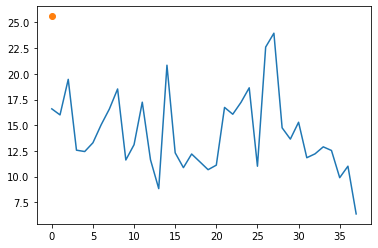

In [100]:
plt.plot(smodel)
plt.plot(check_33, 'o')

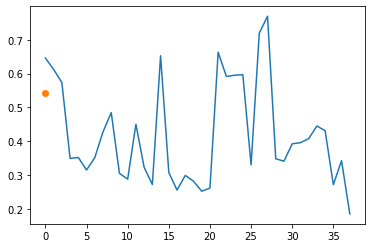

In [101]:
plt.plot(smodel_tcw)
plt.plot(check_3, 'o')

In [46]:
tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc')
tcw_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_tcwv_daily.nc')

u600_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u600_daily.nc')
u925_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u925_daily.nc')

u600_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u600_daily.nc')
u925_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u925_daily.nc')

In [47]:
tcw_diff = tcw_fut-tcw_hist
shear_diff = (u925_fut-u600_fut) - (u925_hist-u600_hist)

In [48]:
hm = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_p95Rain_gt5mm.nc')
fm = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_p95Rain_gt5mm.nc')
hm = hm.sel(latitude=slice(3.5,25), longitude=slice(-20,20))
fm = fm.sel(latitude=slice(3.5,25), longitude=slice(-20,20))

In [49]:
tcw_diff = tcw_diff.sel(latitude=slice(3.5,25), longitude=slice(-20,20))
tcw_hist = tcw_hist.sel(latitude=slice(3.5,25), longitude=slice(-20,20))
shear_diff = shear_diff.sel(latitude=slice(3.5,25), longitude=slice(-20,20))
fm = fm.sel(latitude=slice(3.5,25), longitude=slice(-20,20))
hm = hm.sel(latitude=slice(3.5,25), longitude=slice(-20,20))

In [52]:
tcw_diff

<xarray.Dataset>
Dimensions:                  (latitude: 518, longitude: 939)
Coordinates:
  * latitude                 (latitude) float32 4.0267525 ... 24.965252
  * longitude                (longitude) float32 -17.999756 ... 19.989227
    forecast_reference_time  object 1997-01-01 00:00:00
Data variables:
    tcwv                     (latitude, longitude) float32 19.139908 ... 11.7...

In [53]:
tcw_hist

<xarray.Dataset>
Dimensions:    (latitude: 518, longitude: 939)
Coordinates:
  * latitude   (latitude) float32 4.0267525 4.0672493 ... 24.924747 24.965252
  * longitude  (longitude) float32 -17.999756 -17.959259 ... 19.94873 19.989227
Data variables:
    tcwv       (latitude, longitude) float32 42.543964 42.5088 ... 16.206966

In [54]:
cp4_pos = np.zeros_like(tcw_diff['tcwv'].values)*np.nan
for x in range((tcw_diff['tcwv'].values).shape[1]):
    for y in range((tcw_diff['tcwv'].values).shape[0]):
        pix = tcw_hist['tcwv'].values[y,x]
        try:
            isclose = np.nanargmin(np.abs(pix-ftcw['tcw_hist']))
        except ValueError:
            cp4_pos[y,x] = np.nan
            continue
       # ipdb.set_trace()
        cp4_pos[y,x] = tcwvfac_all[isclose]

ValueError: '' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

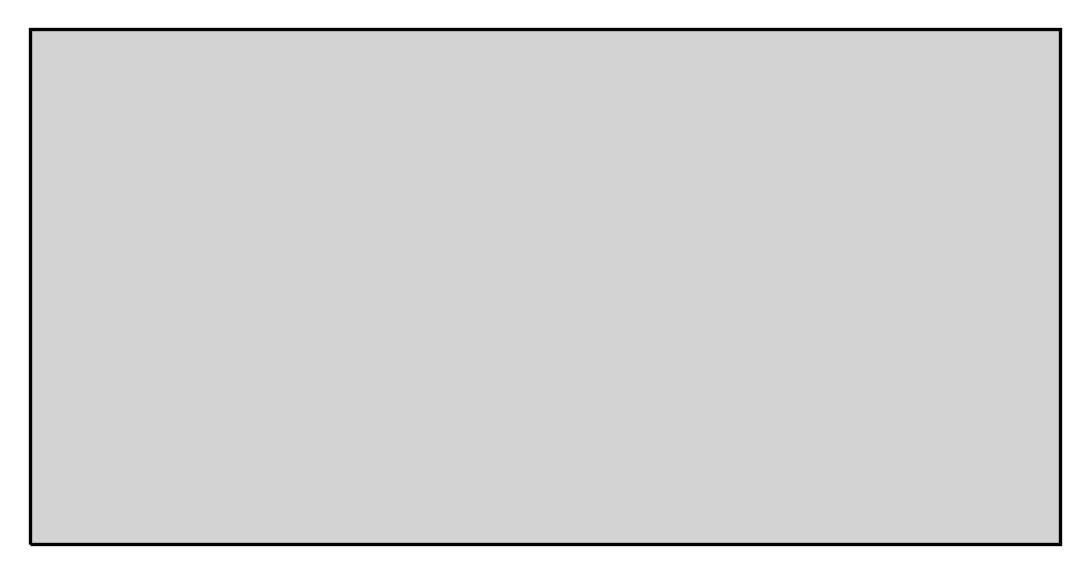

In [56]:
f = plt.figure(figsize=(15,5), dpi=300)

ax = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax, hm, hm.latitude, hm.longitude, title='Historical 95th daily rain (May-Oct)', levels=np.arange(30,81,5), cbarlabel=r'mm day$^-1$')
ax1 = f.add_subplot(222, projection=ccrs.PlateCarree())
draw_map(ax1, fm, fm.latitude, fm.longitude, title='Future 95th daily rain (May-Oct)', levels=np.arange(30,81,5), cbarlabel=r'mm day$^-1$')
ax1 = f.add_subplot(223, projection=ccrs.PlateCarree())
draw_map(ax1, (fm-hm), fm.latitude, fm.longitude, title='Difference median rain (Fut-Hist)', levels=[-30,-25,-20,-15,-10,10,15,20,25,30], cbarlabel=r'mm day$^-1$')
ax1 = f.add_subplot(224, projection=ccrs.PlateCarree())
draw_map(ax1, (fm-hm)/hm*100, fm.latitude, fm.longitude, title='Percentage increase (Fut-Hist)/Hist', levels=[5,10,20,30,40,50,60,70,80], cbarlabel=r'%')
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/rory_check/daily_median_percentIncrease_May-Oct.jpg')